# Bayesian vs Machine Learning Classification Comparison 

### Sabrina Pereira and Ashley Swanson

This notebook explores the differences between the classification outcomes of a machine learning classifier and a naive Bayesian classifier. To do this, we implement the KNN Neighbors Classifier to output roughly the same precision and recall as a naive Bayesian classifier and analyze the similarities and differences of misclassified data points.

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

from scipy.stats import gaussian_kde

from thinkstats2 import Pmf, Cdf, Hist
import thinkplot

from utils import decorate

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt 

## Loading Data

The iris dataset is one of the most widely used datasets for classification. It was originally collected by Edgar Anderson in 1935, and used in R. A. Fisher’s paper [The Use of Multiple Measurements in Taxonomic Problems](http://rcs.chemometrics.ru/Tutorials/classification/Fisher.pdf). This dataset can be downloaded directly from Scikit learn.

Anderson recorded four key physical features for three flowers. The following codes correspond to each flower. 

###### 0=Setosa, 1=Versicolor, 2=Virginica

In [54]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
df0 = pd.DataFrame(X, columns=iris.feature_names)
df = pd.DataFrame(X, columns=iris.feature_names)
df['flower'] = y

sepal length (cm)    5.8
sepal width (cm)     2.7
petal length (cm)    5.1
petal width (cm)     1.9
flower               2.0
Name: 142, dtype: float64

In [14]:
setosa = df[df.flower == 0]
versicolor = df[df.flower == 1].reset_index(drop=True)
virginica = df[df.flower == 2].reset_index(drop=True)

## Data Exploration

To start, we examine a given feature and plot the distribution of measurements for each flower on one plot. This allows for comparison between distributions, and it gives us some sense of what the decisions boundaries might be like for our classifiers. We do the same for the remaining three features. 

/home/spereira/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


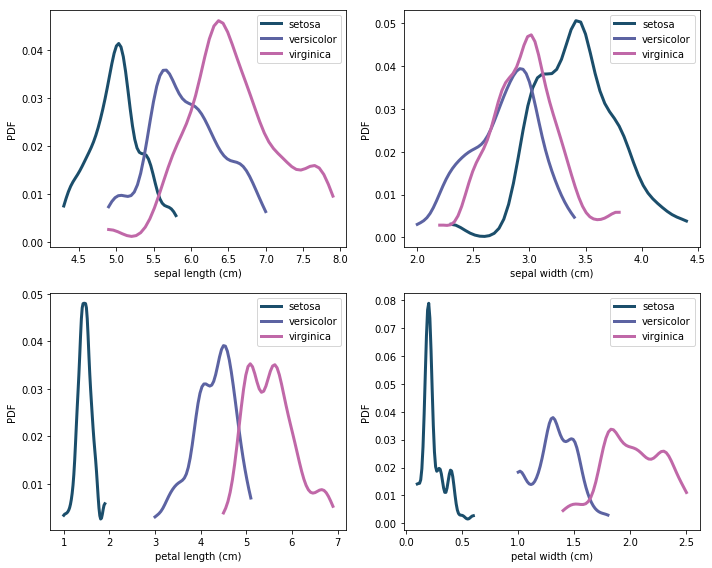

In [15]:
plt.figure(figsize=(10,8))
cl = ['#1B4E6B', '#5C63A2', '#C068A8', 'r']
count = 0
for fl in [setosa,versicolor,virginica]:

    
    for i, feature in enumerate(iris.feature_names):

        kde = gaussian_kde(fl[feature],bw_method=0.3)

        xs = np.linspace(fl[feature].min(), fl[feature].max())
        ds = kde.evaluate(xs)
        ds /= ds.sum()

        plt.subplot(2,2,i+1)

        plt.plot(xs, ds, label=iris.target_names[fl.flower[0]], color=cl[count], linewidth=3.0)

        decorate(xlabel=feature, ylabel='PDF')
    count+=1

From this figure, we can see that some features seem to be more valuable for distinguishing flower types than others. 

For example, in the petal width plot, setosa has no overlap with the other flowers. This means that, within this dataset, setosa is entirely distinguishable from the other flowers with no further information. Versicolor and virginica have little overlap, meaning that petal width would be a good indicator, but there is information to be gained from the features to increase performance.

On the other hand, in the sepal width plot, versicolor and virginica are primarily overlapping. We will see how our different classifiers take all of this information into account!

## Classification 

We used the principle of cross-validation to understand how well our classifiers are operating. We wrote our own functions in order to control how we kept track of the misclassified flowers.

In [28]:
def Bayesian_Classifier(seed):
    '''
    seed: Integer that will set the random_state of the test/train split
    
    returns: a tuple including the score of the classifier and a DataFrame containing information about the misclassified flowers
    
    '''
    
    actual = []
    guess = []
    index = []
    
    X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

    bayes = GaussianNB()
    
    bayes.fit(X_train, y_train)
    y_pred = bayes.predict(X_test)
    mis_class = y_pred-y_test
    
    for i in range(len(mis_class)):
        if(mis_class[i]!=0):
            actual.append(y_test[i])
            guess.append(y_pred[i])
            index.append(X.tolist().index(X_test[i].tolist()))
    temp = pd.DataFrame({'actual':actual, 'guess':guess, 'flower_index':index})
        
    X_test_indices = []
    for flower in X_test:
        X_test_indices.append((X.tolist().index(flower.tolist())))
    
#     return temp
    
    return (bayes.score(X_test, y_test), temp, X_test_indices) 

In [73]:
df['counts'] = 0

bayes_df = pd.DataFrame() # DataFrame we will use to store the incorrect classifications in each iteration
scores = []

for i in range (0, 1000):
    results =  Bayesian_Classifier(i)
    s = results[0]
    temp = results[1]
    increments = results[2]
    
    for j in increments:
        df.loc[j,'counts'] += 1

    scores.append(s)    
    bayes_df = bayes_df.append(temp, ignore_index=True)
    
print(np.mean(scores))
# print(bayes_df)

0.9532666666666667


In [76]:
# df.counts.loc[]

# X[142]

# X.tolist().index(X[142].tolist())


In [30]:
def KNeighbors_Classifier(seed, n):
    '''
    seed: Integer that will set the random_state of the test/train split
    n: Parameter n for number of neighbors in KNeighborsClassifier
    
    returns: a tuple including the score of the classifier and a DataFrame containing information about 
    the misclassified flowers
    
    '''
    actual = []
    guess = []
    index = []
    
    X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    mis_class = y_pred-y_test
    
    for i in range(len(mis_class)):
        if(mis_class[i]!=0):
            actual.append(y_test[i])
            guess.append(y_pred[i])
            index.append(X.tolist().index(X_test[i].tolist()))
    temp = pd.DataFrame({'actual':actual, 'guess':guess, 'flower_index':index})

            
    return (knn.score(X_test, y_test), temp)
            

To ensure that both our Naive Bayesian and k-Nearest Neighbors classifiers classify at a comparable level, we tested out a different values for the n_neighbors parameter to see which would yield a score comparable to the Naive Bayesian classifier.

In [8]:
for k in range(1, 20):
    scores = []

    for i in range (0, 1000):
        s = KNeighbors_Classifier(i, k)[0]
        scores.append(s)

    print(k, ":", np.mean(scores))

1 : 0.9569777777777779
2 : 0.9465777777777779
3 : 0.9614444444444445
4 : 0.9576222222222223
5 : 0.9640444444444445
6 : 0.9614
7 : 0.9647777777777778
8 : 0.9628222222222222
9 : 0.9666444444444445
10 : 0.9629333333333334
11 : 0.967
12 : 0.9636444444444446
13 : 0.9668666666666668
14 : 0.9625555555555556
15 : 0.965288888888889
16 : 0.959088888888889
17 : 0.9609777777777778
18 : 0.9547111111111112
19 : 0.9565111111111112


From this test, we saw that choosing 18 for the n_neighbors parameter got us very close to the same accuracy levels as our Bayesian classifier. 

In [38]:
knn_df = pd.DataFrame() # DataFrame we will use to store the incorrect classifications in each iteration
scores = []

for i in range (0, 1000):
    results = KNeighbors_Classifier(i, 18)
    s = results[0]
    temp = results[1]
    
    scores.append(s)
    knn_df = knn_df.append(temp, ignore_index=True)

print(np.mean(scores))

0.9547111111111112


## Results

To begin to see if the classifiers differ in the flowers that they are misclassifying, for each classifier we will take a look at the breakdown of what type of flowers are commonly misclassified, and what they are misclassified as.

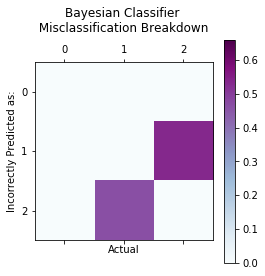

[[0.         0.         0.        ]
 [0.         0.         0.53399905]
 [0.         0.46600095 0.        ]]


In [10]:
# Create matrix for misclassification breakdown
b = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(0, int(bayes_df.size/3)):
    x = int(bayes_df.iloc[i]['actual'])
    y = int(bayes_df.iloc[i]['guess'])
    b[y][x] += 1
A = np.array(b)/int(bayes_df.size/3)

# Display Results
plt.matshow(A, vmin=0, vmax=.66, cmap='BuPu')  
plt.colorbar()
plt.title('Bayesian Classifier \n Misclassification Breakdown \n')
plt.xlabel('Actual')
plt.ylabel('Incorrectly Predicted as:')
plt.show()
print(A)

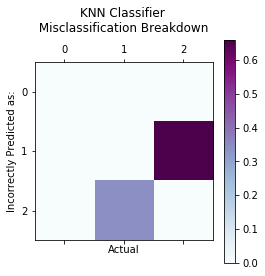

[[0.         0.         0.        ]
 [0.         0.         0.65799804]
 [0.         0.34200196 0.        ]]


In [11]:
# Create matrix for misclassification breakdown
k = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(0, int(knn_df.size/3)):
    x = int(knn_df.iloc[i]['actual'])
    y = int(knn_df.iloc[i]['guess'])
    k[y][x] += 1
K = np.array(k)/int(knn_df.size/3)

# Display Results
plt.matshow(K, vmin=0, vmax=.66, cmap='BuPu')       # same
plt.colorbar()
plt.title('KNN Classifier \n Misclassification Breakdown \n')
plt.xlabel('Actual')
plt.ylabel('Incorrectly Predicted as:')
plt.show()
print(K)

Neither classifier appears to have any difficulty classifying the Setosa flowers (indicated as 0). However, it appears that the while the Bayesian classifier misclassified the Versicolor (1) and Virginica (2) flowers incorrectly as each other about half of the time, the KNN classifier misclassified the Virginica flowers as Versicolor twice as often as the other way around.

We also wanted to find out if the classifier misclassified the same flowers - indicative that the misclassification is due to the ambiguous properties of the flower itself, rather than the properties of the classifier.

To do this, we counted the frequencies of each misclassified flower.

Bayesian Misclassified: Hist({106.0: 315, 119.0: 306, 133.0: 306, 77.0: 305, 70.0: 277, 52.0: 243, 134.0: 194, 83.0: 78, 56.0: 57, 50.0: 16, 86.0: 4, 126.0: 2}) 

KNN Misclassified: Hist({106.0: 315, 83.0: 286, 77.0: 253, 138.0: 232, 126.0: 173, 123.0: 148, 127.0: 140, 119.0: 128, 121.0: 112, 133.0: 86, 70.0: 66, 72.0: 57, 52.0: 35, 113.0: 7})

Bayesian Misclassified: Hist({106.0: 1.0, 119.0: 1.0, 133.0: 0.996742671009772, 77.0: 1.0, 70.0: 1.0, 52.0: 0.7864077669902912, 134.0: 0.6928571428571428, 83.0: 0.2689655172413793, 56.0: 0.1786833855799373, 50.0: 0.050314465408805034, 86.0: 0.01282051282051282, 126.0: 0.007168458781362007}) 

KNN Misclassified: Hist({106.0: 1.0, 83.0: 0.9862068965517241, 77.0: 0.8295081967213115, 138.0: 0.760655737704918, 126.0: 0.6200716845878136, 123.0: 0.5016949152542373, 127.0: 0.45307443365695793, 119.0: 0.41830065359477125, 121.0: 0.3684210526315789, 133.0: 0.28013029315960913, 70.0: 0.23826714801444043, 72.0: 0.1919191919191919, 52.0: 0.11326860841423948,

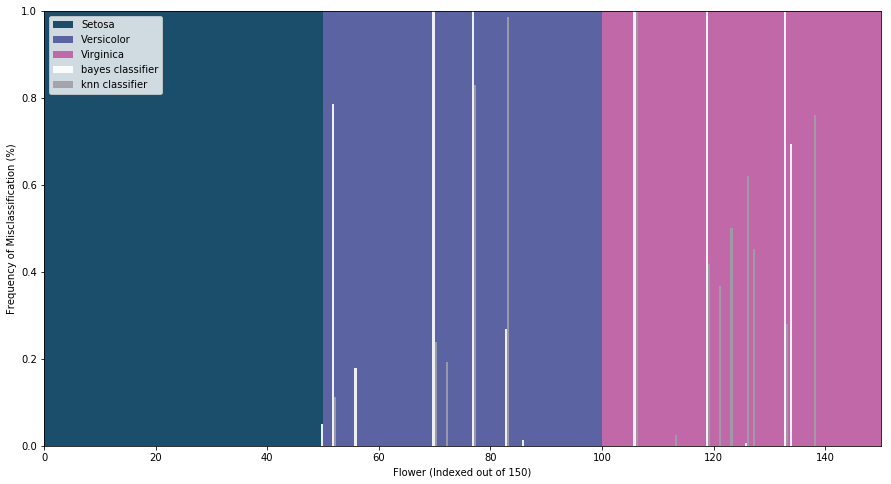

<Figure size 576x432 with 0 Axes>

In [134]:
plt.figure(figsize=(15,8))
plt.xlim(0,150)
plt.ylim(0,1)

bar_width = 50
alpha = 1
plt.bar(25, 1, bar_width, alpha=alpha, color='#1B4E6B', label='Setosa')
plt.bar(75, 1, bar_width, alpha=alpha, color='#5C63A2', label='Versicolor')
plt.bar(125, 1, bar_width, alpha=alpha, color='#C068A8', label='Virginica')

bayes_hist = Hist(bayes_df.flower_index)
knn_hist = Hist(knn_df.flower_index)


print('Bayesian Misclassified:', bayes_hist, '\n')
print('KNN Misclassified:', knn_hist)
print('')

for key in bayes_hist:
    bayes_hist[key] /= df.loc[key,'counts']
    
for key in knn_hist:
    knn_hist[key] /= df.loc[key,'counts']    


print('Bayesian Misclassified:', bayes_hist, '\n')
print('KNN Misclassified:', knn_hist)

bayes_hist.label = 'bayes classifier'
knn_hist.label = 'knn classifier'

thinkplot.PrePlot()
thinkplot.Hist(bayes_hist, align='right', width=.4, color='white', alpha=0.9);
thinkplot.Hist(knn_hist, align='left', width=.4, color='#9F9FA9', alpha=0.9);

thinkplot.Show(xlabel='Flower (Indexed out of 150)', ylabel='Frequency of Misclassification (%)', 
               figsize=(1000,1000));


From the above plot, we can see that there are many ambiguous flowers that are misclassified by both classifiers. However, it is clear that the models are misclassifying different flowers at different frequencies, and there are even some flowers that are often misclassified by one classifier, but never by the other.

For reference, here are the average measurements of each feature for each flower:

In [81]:
average = []

for feature in (iris.feature_names):
    se = round(np.mean(setosa[feature]),2)
    ve = round(np.mean(versicolor[feature]),2)
    vi = round(np.mean(virginica[feature]),2)
    
    print(feature, ":", '   setosa', se, '   versicolor', ve, '   virginica', vi,'\n')
    average.append([se, ve, vi])

sepal length (cm) :    setosa 5.01    versicolor 5.94    virginica 6.59 

sepal width (cm) :    setosa 3.43    versicolor 2.77    virginica 2.97 

petal length (cm) :    setosa 1.46    versicolor 4.26    virginica 5.55 

petal width (cm) :    setosa 0.25    versicolor 1.33    virginica 2.03 



We have selected three flowers of interest to observe.

The first one is the flower that is the MOST misclassified in both classifiers.

In [82]:
print("Flower: ", iris.target_names[int(df.iloc[106]['flower'])], '\n')

flower_A  = []

for feature in (iris.feature_names):
    print(feature, ":", df.iloc[106][feature])
    flower_A.append(df.iloc[106][feature])

Flower:  virginica 

sepal length (cm) : 4.9
sepal width (cm) : 2.5
petal length (cm) : 4.5
petal width (cm) : 1.7


Looking at these traits, we see that the measurements are not in line with what we would expect from a virginica flower - most humans would probably guess versicolor it as well!

The next flower listed was misclassified by the KNN classifier about 76% of the time, but never by the Bayesian classifier.

In [83]:
print("Flower: ", iris.target_names[int(df.iloc[138]['flower'])], '\n')

flower_B = []

for feature in (iris.feature_names):
    print(feature, ":", df.iloc[138][feature])
    flower_B.append(df.iloc[138][feature])

Flower:  virginica 

sepal length (cm) : 6.0
sepal width (cm) : 3.0
petal length (cm) : 4.8
petal width (cm) : 1.8


This flower listed was misclassified by the Bayesian classifier about 69% of the time, but never by the KNN classifier.

In [84]:
print("Flower: ", iris.target_names[int(df.iloc[134]['flower'])], '\n')

flower_C = []

for feature in (iris.feature_names):
    print(feature, ":", df.iloc[134][feature])
    flower_C.append(df.iloc[134][feature])

Flower:  virginica 

sepal length (cm) : 6.1
sepal width (cm) : 2.6
petal length (cm) : 5.6
petal width (cm) : 1.4


These measurements differ from the means in very different ways, indicating that each classifier makes modeling decisions produce suboptimal results under different cases - these models could then theoretically be combined to make a better classifier.




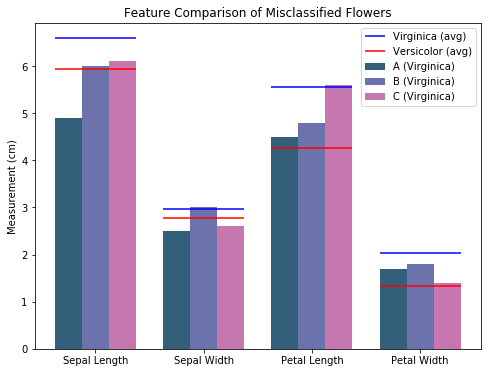

In [91]:
plt.figure(figsize=(8,6))

objects = ('Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width')
y_pos = np.arange(len(objects))

bar_width = .25
line_fac = 1.5

plt.bar(y_pos - bar_width, flower_A, bar_width, alpha=0.9, color='#1B4E6B', label='A (Virginica)')
plt.bar(y_pos, flower_B, bar_width, alpha=0.9, color='#5C63A2', label='B (Virginica)')
plt.bar(y_pos + bar_width, flower_C, bar_width, alpha=0.9, color='#C068A8', label='C (Virginica)')
plt.xticks(y_pos, objects)
plt.ylabel('Measurement (cm)')
plt.title('Feature Comparison of Misclassified Flowers')

plt.hlines(average[0][2], y_pos[0]-bar_width*line_fac, y_pos[0]+bar_width*line_fac, colors='blue', 
           linestyles='solid', label='Virginica (avg)')
plt.hlines(average[0][1], y_pos[0]-bar_width*line_fac, y_pos[0]+bar_width*line_fac, colors='red', 
           linestyles='solid', label='Versicolor (avg)')

for i in range(1, 4):
    plt.hlines(average[i][2], y_pos[i]-bar_width*line_fac, y_pos[i]+bar_width*line_fac, colors='blue', 
               linestyles='solid')    
    plt.hlines(average[i][1], y_pos[i]-bar_width*line_fac, y_pos[i]+bar_width*line_fac, colors='red', 
               linestyles='solid')

    
plt.legend()
plt.show()